**Table of contents**<a id='toc0_'></a>    
- [When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues](#toc1_)    
  - [Step 1](#toc1_1_)    
    - [Identify Components Most Implicated in Recalls](#toc1_1_1_)    
      - [Recalls EDA](#toc1_1_1_1_)    
      - [Filter for Manufacturers of Interest](#toc1_1_1_2_)    
      - [Split Components](#toc1_1_1_3_)    
  - [Step 2](#toc1_2_)    
    - [Load and Clean Complaints Data](#toc1_2_1_)    
      - [Complaints EDA](#toc1_2_1_1_)    
      - [Extract Select Complaints Data](#toc1_2_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [316]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [317]:
def remove_punct(df):
    """
    Removes semantically meaningless punctuation (components use : to denote hierarchy)
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O" and col != "COMPNAME" and col != "COMPDESC":
                df.loc[:, col] = df[col].str.replace(r"[^\w\s-]", "", regex=True)
        except AttributeError as e:
            print(f"Check for non-string datatypes in {col}: {e}")


def lowercase(df):
    """
    Converts text to lowercase.
    Parameters:
        df (dataframe): dataframe containing text for cleaning
    Returns:
        dataframe
    """
    cols = df.columns
    for col in cols:
        try:
            if df[col].dtype == "O":
                df.loc[:, col] = df[col].str.lower()
        except AttributeError as e:
            print(f"Check for non-string datatypes: {e}")


def convert_datetime(data, columns=None, format="%Y%m%d", errors="coerce"):
    """
    Converts given columns to datetime.
    Parameters:
        data (pandas.DataFrame): The DataFrame containing the data to be converted.
        columns (list | None): The list of column names to be converted to datetime (default is ["RCDATE", "DATEA"]).
        format (str, optional): The format string used to parse the datetime columns (default is "%Y%m%d").
        errors (str, optional): How to handle parsing errors. Options are "raise", "coerce",
          and "ignore" (default is "coerce", which converts parsing errors to NaT).

    Returns:
        None: The function modifies the input DataFrame in place
    """
    if columns is None:
        columns = ["RCDATE", "DATEA", "ODATE", "BGMAN", "ENDMAN"]
    for col in columns:
        data[col] = pd.to_datetime(data[col].astype(str), format=format, errors=errors)

# <a id='toc1_'></a>[When the Customer Is Right: Analyzing Automotive Customer Complaint Data to Identify Serious Safety Issues](#toc0_)

## <a id='toc1_1_'></a>[Step 1](#toc0_)
### <a id='toc1_1_1_'></a>[Identify Components Most Implicated in Recalls](#toc0_)

In [318]:
# Load recall data
recalls_headers = pd.read_csv("./data/RCL_headers.txt")
recalls_head = recalls_headers.values.tolist()
rcl_headers = [head for sublist in recalls_head for head in sublist]

recalls = pd.read_csv(
    "./data/FLAT_RCL.txt", sep="\t", names=rcl_headers, on_bad_lines="warn"
)

Skipping line 188394: expected 27 fields, saw 34

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_3381/2183926908.py:6: DtypeWarning: Columns (17,18,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  recalls = pd.read_csv(


In [319]:
# Examine mixed dtypes for potential problems
recalls.iloc[:, [17,18,24,25,26]].sample(10)


,RPNO,FMVSS,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
97084,NaN,NaN,NaN,NaN,NaN
132060,NaN,NaN,NaN,NaN,NaN
203104,NaN,NaN,AIRBAG ASM-STRG WHL,Driver Front Airbag Inflator,"23165546, 23165547, 23165548, 23165553, 23165554"
152593,NaN,NaN,Power Distribution Module,Power Distribution Module,A66-05172-002
16567,571.0,217.0,NaN,NaN,NaN
116793,NaN,NaN,NaN,NaN,NaN
117155,NaN,110,NaN,NaN,NaN
64659,NaN,NaN,NaN,NaN,NaN
36701,NaN,NaN,NaN,NaN,NaN
106373,NaN,NaN,NaN,NaN,NaN


In [320]:
recalls.sample(2)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
74770,74771,08V020000,PIERCE,VELOCITY,2007,NaN,STEERING:GEAR BOX:SHAFT PITMAN,PIERCE MANUFACTURING,20070929.0,20071129.0,...,NaN,NaN,ON CERTAIN FIRE TRUCKS EQUIPPED WITH TRW STEER...,THIS CONDITION HAS THE POTENTIAL TO CAUSE THE ...,PIERCE IS WORKING WITH TRW TO REPLACE THE DEFE...,CUSTOMERS MAY ALSO CONTACT THE NATIONAL HIGHWA...,000025791000342653000000007,NaN,NaN,NaN
226034,226038,22V365000,MERCEDES-BENZ,SLC300,2020,2022060005,ELECTRICAL SYSTEM:SOFTWARE,"Mercedes-Benz USA, LLC",NaN,NaN,...,NaN,NaN,"Mercedes-Benz USA, LLC (MBUSA) is recalling ce...",A disabled eCall system would prevent a vehicl...,The communication module software will be upda...,Owners may also contact the National Highway T...,000120389004286731000001105,SW communication module,SW communication module,A2479026100


In [321]:
recalls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248841 entries, 0 to 248840
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   RECORD_ID          248841 non-null  int64  
 1   CAMPNO             248841 non-null  object 
 2   MAKETXT            248841 non-null  object 
 3   MODELTXT           248841 non-null  object 
 4   YEARTXT            248841 non-null  int64  
 5   MFGCAMPNO          150692 non-null  object 
 6   COMPNAME           248841 non-null  object 
 7   MFGNAME            248836 non-null  object 
 8   BGMAN              115289 non-null  float64
 9   ENDMAN             115533 non-null  float64
 10  RCLTYPECD          248841 non-null  object 
 11  POTAFF             248555 non-null  float64
 12  ODATE              236645 non-null  float64
 13  INFLUENCED_BY      248841 non-null  object 
 14  MFGTXT             248841 non-null  object 
 15  RCDATE             248841 non-null  int64  
 16  DA

In [322]:
# Basic data cleaning
lowercase(recalls)
remove_punct(recalls)
convert_datetime(recalls)
convert_datetime(recalls, columns=["YEARTXT"], format="%Y")
recalls.sample(10)

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,RPNO,FMVSS,DESC_DEFECT,CONEQUENCE_DEFECT,CORRECTIVE_ACTION,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO
29052,29053,85v116000,ford,bronco ii,1986-01-01,NaN,electrical system:wiring:front underhood,ford motor company,NaT,NaT,...,NaN,NaN,the electronic engine control wiring harness i...,NaN,repair wiring harness check engine and catalys...,vehicle description light trucks equipped with...,000004578000005539000000208,NaN,NaN,NaN
5362,5363,00v328000,land rover,range rover,1997-01-01,d221d222,engine and engine cooling:cooling system:hoses...,land rover north america inc,NaT,NaT,...,NaN,NaN,vehicle description sport utility vehicles ...,consequently the fluid could ignite causing an...,dealers will make a series of modifications to...,owner notification began january 4 2001owners ...,000011863000074204000000137,NaN,NaN,NaN
175745,175746,21v058000,mercedes-benz,amg gla35,2021-01-01,2021020025,communication: auto crash notification,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,failure of the ecall system may result in emer...,mbusa will notify owners and the communication...,owners may also contact the national highway t...,000108471004472742000001420,sw hermes,control module unit software,a2229026719
11483,11484,99v018000,blue bird,conventional,1988-01-01,r99cn,seats,blue bird body company,NaT,NaT,...,NaN,NaN,vehicle description school buses the wall si...,in the event of a frontal crash the rear attac...,blue bird will furnish to distributors and own...,owner notification began april 28 and july 29 ...,000008982000062274000000318,NaN,NaN,NaN
119419,119420,15v698000,four winds,hurricane,2011-01-01,rc000106,electrical system,thor motor coach,NaT,NaT,...,NaN,NaN,thor motor coach tmc is recalling certain mode...,as the transfer switch fails it may overheat i...,tmc will notify owners and dealers will replac...,owners may also contact the national highway t...,000058179001061770000000200,NaN,NaN,NaN
9696,9697,99v165001,winnebago,wg34h,1999-01-01,NaN,"service brakes, hydraulic:brake fluid low warn...",winnebago industries inc,NaT,NaT,...,NaN,NaN,vehicle description motor homes built on a fo...,the bulbsocket assembly may not function properly,dealers will place the brake system warning in...,owner notification began may 20 1999owners who...,000009238000082834000000065,NaN,NaN,NaN
156660,156661,20v747000,nissan,sentra,2003-01-01,pm964,air bags:frontal:passenger side:inflator module,nissan north america inc,NaT,NaT,...,NaN,NaN,nissan north america inc nissan is recalling c...,an inflator explosion may result in sharp meta...,nissan will notify owners and dealers will re-...,owners may also contact the national highway t...,000107332000201626000001463,spi inflator-air bag asst,spi inflator for front passenger air bag module,985614z60a
141465,141466,20v206000,vac-tron,mc 873 sdt,2016-01-01,vvk0006,structure,vac-tron equipment llc,NaT,NaT,...,NaN,NaN,vac-tron equipment llc vac-tron is recalling c...,in the event of a rear impact crash the other ...,vac-tron will notify owners and vermeer dealer...,owners may also contact the national highway t...,000102534004348767000000272,NaN,NaN,NaN
177554,177555,21v058000,mercedes-benz,amg e63,2018-01-01,2021020025,communication: auto crash notification,mercedes-benz usa llc,NaT,NaT,...,NaN,NaN,mercedes-benz usa llc mbusa is recalling certa...,failure of the ecall system may result in emer...,mbusa will notify owners and the communication...,owners may also contact the national highway t...,000108471004309717000001420,sw hermes,control module unit software,a2229027718
55419,55420,67v086000,reo,df,1967-01-01,NaN,steering:linkages:drag:link:connection,white motor corporation,NaT,NaT,...,NaN,NaN,NaN,NaN,NaN,possible material deficiency which may affect ...,000000156000046094000000016,NaN,NaN,NaN


In [323]:
recalls["ODATE"]

0        NaT
1        NaT
2        NaT
3        NaT
4        NaT
          ..
248836   NaT
248837   NaT
248838   NaT
248839   NaT
248840   NaT
Name: ODATE, Length: 248841, dtype: datetime64[ns]

#### <a id='toc1_1_1_1_'></a>[Recalls EDA](#toc0_)

In [324]:
# Number of recall campaigns
print(f"Recall campaigns count: {len(recalls['CAMPNO'].unique())}")

# Number of unique components recalled
print(f"Number of unique components recalled: {len(recalls['RCL_CMPT_ID'].unique())}")

# Timeframe of Complaints
print(f"Earliest recall report: {min(recalls['RCDATE'])}\n Most recent recall report: {max(recalls['RCDATE'])}")

Recall campaigns count: 27436
Number of unique components recalled: 176081
Earliest recall report: 1966-01-19 00:00:00
 Most recent recall report: 2023-11-10 00:00:00


In [325]:
# Check for variations in manufacturer name for companies of interest
# GM, Toyota, Tesla, Ford, Hyundai, Honda
gm = recalls.query('MFGNAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['general motors corp', 'general motors llc']

In [326]:
toyota = recalls.query('MFGNAME.str.contains("toyota", case=False, na=False)')
toyota.loc[toyota["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['toyota motor north america inc',
 'southeast toyota distributors',
 'gulf states toyota inc',
 'toyota motor co ltd',
 'toyota motor engineering  manufacturing',
 'southeast toyota distributors llc']

In [327]:
tesla = recalls.query('MFGNAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['tesla motors inc', 'tesla motors', 'tesla inc']

In [328]:
ford = recalls.query('MFGNAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['ford motor company',
 'ford mtr co-overseas',
 'zf lemforder corporation',
 'ford motor company test adw as',
 'c  c ford']

In [329]:
hyundai = recalls.query('MFGNAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['hyundai motor company',
 'hyundai caribbean-puerto rico',
 'hyundai translead',
 'hyundai motor america',
 'hyundai truck america']

In [330]:
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda american honda motor co', 'honda of minola']

In [331]:
# Standardize manufacturer names
recalls["MFGNAME"].replace(
    {
        "general motors llc": "general motors corp",
        "tesla motors inc": "tesla inc",
        "tesla motors": "tesla inc",
        "honda american honda motor co": "american honda motor co",
    },
    inplace=True,
)

In [332]:
# Check standardization
honda = recalls.query('MFGNAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFGNAME"].duplicated() == False, "MFGNAME"].tolist()

['american honda motor co', 'honda of minola']

In [333]:
recalls_mfr_count = pd.DataFrame(recalls["MFGNAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in recall data:\n{recalls_mfr_count[:20]}"
)

Top 20 manufacturers most represented in recall data:
                                         count
MFGNAME                                       
mercedes-benz usa llc                    41784
ford motor company                       12779
general motors corp                      10062
american honda motor co                   7044
daimler trucks north america llc          6932
paccar incorporated                       4920
forest river inc                          4637
nissan north america inc                  3593
bmw of north america llc                  3550
toyota motor engineering  manufacturing   3181
volkswagen group of america inc           3156
jaguar land rover north america llc       3015
chrysler corporation                      2804
chrysler fca us llc                       2670
blue bird body company                    2619
winnebago industries inc                  2306
navistar inc                              2276
prevost car us inc                        2270
daimle

In [334]:
recalls_mfr_count["percentage_of_recalls"] = recalls_mfr_count["count"] / len(recalls)
recalls_mfr_count.sort_values(by="percentage_of_recalls", ascending=False)[:20]

,count,percentage_of_recalls
MFGNAME,,
mercedes-benz usa llc,41784,0.167914
ford motor company,12779,0.051354
general motors corp,10062,0.040435
american honda motor co,7044,0.028307
daimler trucks north america llc,6932,0.027857
paccar incorporated,4920,0.019772
forest river inc,4637,0.018634
nissan north america inc,3593,0.014439
bmw of north america llc,3550,0.014266


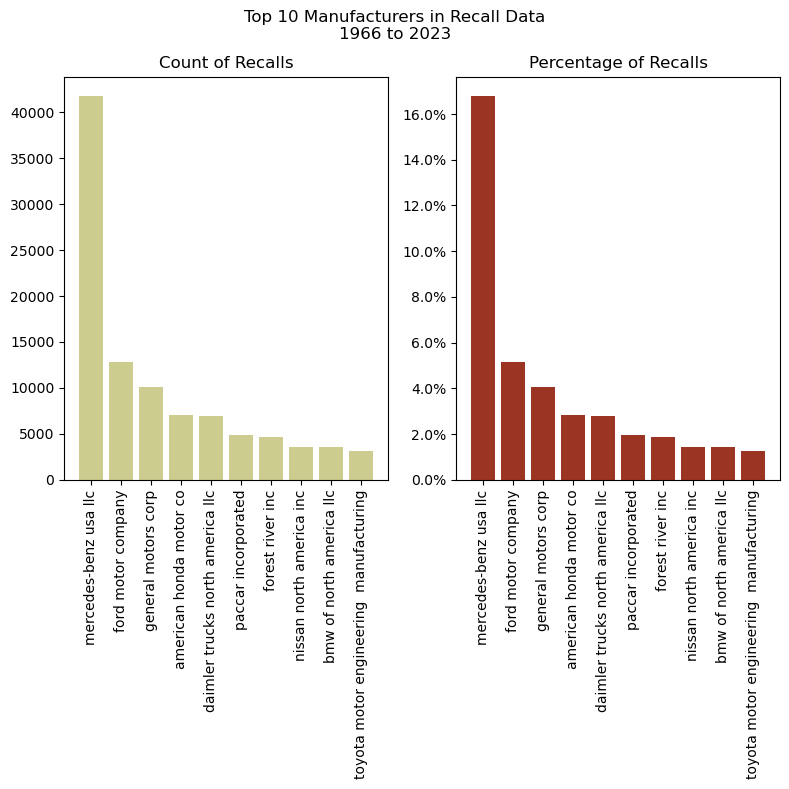

In [335]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
ax1.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["count"][:10],
    color="#cbcc8d",
)
ax1.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax1.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax1.set_title("Count of Recalls")

ax2.bar(
    recalls_mfr_count.reset_index()["MFGNAME"][:10],
    recalls_mfr_count["percentage_of_recalls"][:10],
    color="#9c3424",
)
ax2.set_xticks(recalls_mfr_count.reset_index()["MFGNAME"][:10])
ax2.set_xticklabels(recalls_mfr_count.reset_index()["MFGNAME"][:10], rotation=90)
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_title("Percentage of Recalls")
plt.suptitle("Top 10 Manufacturers in Recall Data\n1966 to 2023")
plt.tight_layout()

In [336]:
# Get list of recall-prone components
rcl_common_compnames = pd.DataFrame(
    recalls["COMPNAME"].value_counts(ascending=False)[:50]
).reset_index()
rcl_common_compnames.to_csv("./output/allrcl_common_comps.csv")
rcl_common_compnames

,COMPNAME,count
0,electrical system:software,18922
1,communication: auto crash notification,16630
2,equipment,11825
3,equipment:recreational vehicle/trailer,8015
4,equipment adaptive/mobility,5201
5,exterior lighting,4945
6,equipment:other:labels,4927
7,air bags:frontal:passenger side:inflator module,4440
8,electrical system,4364
9,"fuel system, gasoline:delivery:fuel pump",4111


#### <a id='toc1_1_1_2_'></a>[Filter for Manufacturers of Interest](#toc0_)

In [337]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]
recalls_filtered = recalls[recalls["MFGNAME"].isin(select_mfrs)]
recalls_filtered["MFGNAME"].value_counts()

MFGNAME
ford motor company                12779
general motors corp               10062
american honda motor co            7044
hyundai motor america               952
tesla inc                           607
toyota motor north america inc      477
Name: count, dtype: int64

#### <a id='toc1_1_1_3_'></a>[Split Components](#toc0_)

In [338]:
parts = recalls_filtered["COMPNAME"].str.split(":", expand=True)
parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(parts.columns))]
parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,electrical system,12v/24v/48v battery,cables,None,None
1,electrical system,12v/24v/48v battery,cables,None,None
48,wheels,None,None,None,None
49,wheels,None,None,None,None
148,"fuel system, other",storage,tank assembly,None,None
...,...,...,...,...,...
248696,electrical system,None,None,None,None
248697,electrical system,None,None,None,None
248698,electrical system,None,None,None,None
248723,power train,driveline,driveshaft,None,None


In [339]:
rcls_filter_enrich = pd.concat([recalls_filtered, parts], axis=1)
rcls_filter_enrich.head()

,RECORD_ID,CAMPNO,MAKETXT,MODELTXT,YEARTXT,MFGCAMPNO,COMPNAME,MFGNAME,BGMAN,ENDMAN,...,NOTES,RCL_CMPT_ID,MFR_COMP_NAME,MFR_COMP_DESC,MFR_COMP_PTNO,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
0,1,02v288000,ford,focus,2000-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015339000215021000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
1,2,02v288000,ford,focus,2001-01-01,02s41,electrical system:12v/24v/48v battery:cables,ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015339000215022000000202,NaN,NaN,NaN,electrical system,12v/24v/48v battery,cables,None,None
48,49,02v250000,honda,silver wing,2002-01-01,NaN,wheels,american honda motor co,NaT,NaT,...,also customers can contact the national highwa...,000015234000106389000000309,NaN,NaN,NaN,wheels,None,None,None,None
49,50,02v250000,honda,fsc600,2002-01-01,NaN,wheels,american honda motor co,NaT,NaT,...,also customers can contact the national highwa...,000015234000106390000000309,NaN,NaN,NaN,wheels,None,None,None,None
148,149,02v249000,ford,crown victoria,2002-01-01,02s39,"fuel system, other:storage:tank assembly",ford motor company,NaT,NaT,...,also contact the national highway traffic safe...,000015251000215009000000162,NaN,NaN,NaN,"fuel system, other",storage,tank assembly,None,None


## <a id='toc1_2_'></a>[Step 2](#toc0_)
### <a id='toc1_2_1_'></a>[Load and Clean Complaints Data](#toc0_)

In [340]:
complt_headers = pd.read_csv("./data/CMPL_headers.txt")
complt_head = complt_headers.values.tolist()
cmpl_headers = [head for sublist in complt_head for head in sublist]

cmpl = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")

Skipping line 555891: expected 49 fields, saw 70

/var/folders/4x/y38ttwq12519_qtj737r25vh0000gn/T/ipykernel_3381/2997329469.py:5: DtypeWarning: Columns (15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  cmpl = pd.read_csv("./data/FLAT_CMPL.txt", sep="\t", names=cmpl_headers, on_bad_lines="warn")


In [341]:
# NOTE: CMPLID appears to just be the row number (index)
cmpl.head(2)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1,958241,"Volvo Car USA, LLC",VOLVO,760,1987.0,N,NaN,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N
2,958130,Ford Motor Company,FORD,THUNDERBIRD,1992.0,N,19941222.0,N,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,V,NaN,N,N


In [342]:
# Examine mixed dtypes for potential problems
print(cmpl.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].dtypes)

cmpl.iloc[:, [15,16,18,27,28,29,30,32,33,34,35,38,39,40,41,42,43,44]].sample(5)

LDATE              object
MILES             float64
CDESCR             object
FUEL_SYS           object
FUEL_TYPE          object
TRANS_TYPE         object
VEH_SPEED         float64
TIRE_SIZE          object
LOC_OF_TIRE        object
TIRE_FAIL_TYPE     object
ORIG_EQUIP_YN      object
RESTRAINT_TYPE     object
DEALER_NAME        object
DEALER_TEL         object
DEALER_CITY        object
DEALER_STATE       object
DEALER_ZIP         object
PROD_TYPE          object
dtype: object


,LDATE,MILES,CDESCR,FUEL_SYS,FUEL_TYPE,TRANS_TYPE,VEH_SPEED,TIRE_SIZE,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE
1090902,20140727,NaN,THE AIR BAG WARNING LIGHT TURNS ON AND OFF. I...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
185169,19991124,NaN,BOTH DRIVER / FRONT PASSENGER REAR ELECTRON...,F,GS,AUTO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1867854,20230126,116000.0,The contact owns a 2014 Ford Explorer. The con...,NaN,NaN,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1147578,20150114,119236.0,WELL I WAS DRIVING ALONG AND ALL OF A SUDDEN J...,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V
1892665,20230508,NaN,Noticed that I have been low on antifreeze/coo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V


In [343]:
cmpl["LDATE"]

1          19950103
2          19950103
3          19950103
4          19950103
5          19950103
             ...   
1944091    20231123
1944092    20231123
1944093    20231123
1944094    20231123
1944095    20231123
Name: LDATE, Length: 1943098, dtype: object

In [344]:
# cmpl["LDATE"] = pd.to_datetime(cmpl["LDATE"], format="%Y%m%d", errors="coerce")

In [345]:
# cmpl["LDATE"]

In [346]:
# Convert to datetime
convert_datetime(cmpl, columns=["FAILDATE", "DATEA", "LDATE", "PURCH_DT", "MANUF_DT"])
cmpl["YEARTXT"] = pd.to_datetime(cmpl["YEARTXT"], format="%Y", errors="coerce")

In [347]:
cmpl["LDATE"]

1         1995-01-03
2         1995-01-03
3         1995-01-03
4         1995-01-03
5         1995-01-03
             ...    
1944091   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
1944094   2023-11-23
1944095   2023-11-23
Name: LDATE, Length: 1943098, dtype: datetime64[ns]

In [348]:
cmpl["YEARTXT"]

1         1987-01-01
2         1992-01-01
3         1994-01-01
4         1987-01-01
5         1991-01-01
             ...    
1944091   2015-01-01
1944092   2014-01-01
1944093   2014-01-01
1944094   2011-01-01
1944095   2022-01-01
Name: YEARTXT, Length: 1943098, dtype: datetime64[ns]

In [349]:
# Basic data cleaning
lowercase(cmpl)
remove_punct(cmpl)
cmpl.sample(10)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,DEALER_NAME,DEALER_TEL,DEALER_CITY,DEALER_STATE,DEALER_ZIP,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1714312,11384265,general motors llc,gmc,sierra 1500,2020-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
765170,10312580,general motors llc,chevrolet,cobalt,2005-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
792720,10335737,general motors llc,chevrolet,s10,1997-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1145130,10670494,general motors llc,chevrolet,malibu,2008-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
252394,734922,ford motor company,ford,focus,2000-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1817248,11468173,general motors llc,chevrolet,silverado 1500,2003-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
899273,10443216,ford motor company,ford,f-350,2006-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1595511,11245042,ford motor company,ford,fusion,2010-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n
1784100,11444730,honda american honda motor co,acura,tlx,2015-01-01,n,NaT,n,0,0,...,NaN,duncan acura,5405620099,roanoke,va,24017,v,NaN,n,n
928853,10466449,ford motor company,ford,windstar,2001-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,v,NaN,n,n


In [350]:
# Remove irrelevant Dealership information
cmpl.drop(["DEALER_NAME", "DEALER_TEL", "DEALER_CITY", "DEALER_STATE", "DEALER_ZIP",], axis=1, inplace=True)
cmpl.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN'],
      dtype='object')

In [351]:
gm = cmpl.query('MFR_NAME.str.contains("general motors", case=False, na=False)')
gm.loc[gm["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['general motors llc']

In [352]:
toy = cmpl.query('MFR_NAME.str.contains("toyota", case=False, na=False)')
toy.loc[toy["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['toyota motor corporation', 'toyota motor engineering  manufacturing']

In [353]:
tesla = cmpl.query('MFR_NAME.str.contains("tesla", case=False, na=False)')
tesla.loc[tesla["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['tesla inc']

In [354]:
ford = cmpl.query('MFR_NAME.str.contains("ford", case=False, na=False)')
ford.loc[ford["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['ford motor company']

In [355]:
hyundai = cmpl.query('MFR_NAME.str.contains("hyundai", case=False, na=False)')
hyundai.loc[hyundai["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['hyundai motor america',
 'hyundai truck service',
 'hyundai caribbean-puerto rico',
 'hyundai translead']

In [356]:
honda = cmpl.query('MFR_NAME.str.contains("honda", case=False, na=False)')
honda.loc[honda["MFR_NAME"].duplicated() == False, "MFR_NAME"].tolist()

['honda american honda motor co']

In [357]:
# Standardize MFR_NAME for select manufacturers
replace_map = {
    "general motors llc": "general motors corp",
    "honda american honda motor co": "american honda motor co",
    "toyota motor corporation": "toyota motor north america inc",
}

cmpl.loc[:, "MFR_NAME"] = cmpl["MFR_NAME"].replace(replace_map)
cmpl[cmpl["MFR_NAME"] == "american honda motor co"][:2]

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
25,958184,american honda motor co,honda,accord,1990-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
77,958120,american honda motor co,honda,civic,1994-01-01,y,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


#### <a id='toc1_2_1_1_'></a>[Complaints EDA](#toc0_)

In [358]:
# Number of complaints
print(f"Complaints count: {len(cmpl)}")

# Number of unique components recalled
print(f"Number of unique components implicated: {len(cmpl['COMPDESC'].unique())}")

# Timeframe of Complaints
print(f"Earliest Complaint: {min(cmpl['LDATE'])}\n Most recent complaint: {max(cmpl['LDATE'])}")

Complaints count: 1943098
Number of unique components implicated: 727
Earliest Complaint: 1995-01-01 00:00:00
 Most recent complaint: 2023-11-23 00:00:00


In [359]:
cmpl_mfr_count = pd.DataFrame(cmpl["MFR_NAME"].value_counts(ascending=False))

print(
    f"Top 20 manufacturers most represented in complaints data:\n{cmpl_mfr_count[:20]}"
)

Top 20 manufacturers most represented in complaints data:
                                      count
MFR_NAME                                   
general motors corp                  404556
ford motor company                   376858
chrysler fca us llc                  353781
toyota motor north america inc       139809
american honda motor co              108234
nissan north america inc              95550
hyundai motor america                 58621
volkswagen group of america inc       55422
kia america inc                       45291
bmw of north america llc              39965
subaru of america inc                 29985
mercedes-benz usa llc                 27487
mazda motor corp                      25149
tesla inc                             14472
mitsubishi motors north america inc   13713
unknown manufacturer                  13060
volvo car usa llc                     11662
suzuki motor usa llc                   6524
goodyear tire  rubber company          5793
isuzu motors limit

#### <a id='toc1_2_1_2_'></a>[Extract Select Complaints Data](#toc0_)

In [360]:
select_mfrs = [
    "general motors corp",
    "tesla inc",
    "toyota motor north america inc",
    "ford motor company",
    "american honda motor co",
    "hyundai motor america",
]

cmpl_filtered = cmpl[cmpl["MFR_NAME"].isin(select_mfrs) == True]
cmpl_filtered.sample(5)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,LOC_OF_TIRE,TIRE_FAIL_TYPE,ORIG_EQUIP_YN,MANUF_DT,SEAT_TYPE,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN
1022248,10552634,ford motor company,ford,escape,2006-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
644192,10207437,ford motor company,ford,econoline,2003-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
1572632,11218377,ford motor company,ford,escape,2011-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
553794,10136082,general motors corp,buick,lesabre,2000-01-01,n,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n
145598,836488,general motors corp,chevrolet,cavalier,1997-01-01,y,NaT,n,0,0,...,NaN,NaN,NaN,NaT,NaN,NaN,v,NaN,n,n


In [361]:
cmpl_parts = cmpl_filtered["COMPDESC"].str.split(":", expand=True)
cmpl_parts.columns = [f"COMPSYS_{i + 1}" for i in range(len(parts.columns))]
cmpl_parts

,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,"fuel system, gasoline",delivery,None,None,None
6,power train,None,None,None,None
7,air bags,frontal,None,None,None
14,"fuel system, gasoline",storage,tank assembly,None,None
15,steering,hydraulic power assist system,None,None,None
...,...,...,...,...,...
1944088,engine,None,None,None,None
1944092,electrical system,None,None,None,None
1944093,seat belts,None,None,None,None
1944094,steering,None,None,None,None


In [362]:
cmpl_filtered_enrich = pd.concat([cmpl_filtered, cmpl_parts], axis=1)
cmpl_filtered_enrich.head(3)

,ODINO,MFR_NAME,MAKETXT,MODELTXT,YEARTXT,CRASH,FAILDATE,FIRE,INJURED,DEATHS,...,RESTRAINT_TYPE,PROD_TYPE,REPAIRED_YN,MEDICAL_ATTN,VEHICLES_TOWED_YN,COMPSYS_1,COMPSYS_2,COMPSYS_3,COMPSYS_4,COMPSYS_5
2,958130,ford motor company,ford,thunderbird,1992-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,"fuel system, gasoline",delivery,None,None,None
6,958246,ford motor company,ford,aerostar,1990-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,power train,None,None,None,None
7,958248,hyundai motor america,hyundai,elantra,1994-01-01,n,NaT,n,0,0,...,NaN,v,NaN,n,n,air bags,frontal,None,None,None


In [363]:
cmpl_filtered_enrich.shape

(1102550, 48)

In [364]:
# Filter for recall-prone parts
# Selected easily identifiable and commonly recalled parts
select_parts = [
    "air bags",
    "seat belts",
    "service brakes",
    "fuel system, gasoline",
    "power train",
    "visibility",
    "electrical system",
    "vehicle speed control",
    "wheels",
    "engine",
    "suspension",
]

cmpl_select_parts = cmpl_filtered_enrich[cmpl_filtered_enrich["COMPSYS_1"].isin(select_parts) == True].copy(deep=True)

In [365]:
print(cmpl_select_parts.shape)
cmpl_select_parts["COMPSYS_1"].value_counts()

(599331, 48)


COMPSYS_1
electrical system        116080
power train              101529
air bags                  83082
engine                    65238
vehicle speed control     53195
suspension                46163
service brakes            39831
visibility                32801
fuel system, gasoline     27521
seat belts                21256
wheels                    12635
Name: count, dtype: int64

In [366]:
cmpl_select_parts.to_csv("./output/cmpl_select_parts.csv")

In [367]:
cmpl_compsys = pd.DataFrame(cmpl_select_parts["COMPSYS_1"].value_counts())
cmpl_compsys = cmpl_compsys.reset_index()
cmpl_compsys.rename(columns={"COMPSYS_1": "compsys", "count": "num_complaints"}, inplace=True)
cmpl_compsys.to_csv("./output/cmpl_select_compsys_summary.csv")

## Step 3

### Trend Detection

#### Plot Raw Component Complaint Counts by Month

In [368]:
cmpl_select_parts.columns

Index(['ODINO', 'MFR_NAME', 'MAKETXT', 'MODELTXT', 'YEARTXT', 'CRASH',
       'FAILDATE', 'FIRE', 'INJURED', 'DEATHS', 'COMPDESC', 'CITY', 'STATE',
       'VIN', 'DATEA', 'LDATE', 'MILES', 'OCCURENCES', 'CDESCR', 'CMPL_TYPE',
       'POLICE_RPT_YN', 'PURCH_DT', 'ORIG_OWNER_YN', 'ANTI_BRAKES_YN',
       'CRUISE_CONT_YN', 'NUM_CYLS', 'DRIVE_TRAIN', 'FUEL_SYS', 'FUEL_TYPE',
       'TRANS_TYPE', 'VEH_SPEED', 'DOT', 'TIRE_SIZE', 'LOC_OF_TIRE',
       'TIRE_FAIL_TYPE', 'ORIG_EQUIP_YN', 'MANUF_DT', 'SEAT_TYPE',
       'RESTRAINT_TYPE', 'PROD_TYPE', 'REPAIRED_YN', 'MEDICAL_ATTN',
       'VEHICLES_TOWED_YN', 'COMPSYS_1', 'COMPSYS_2', 'COMPSYS_3', 'COMPSYS_4',
       'COMPSYS_5'],
      dtype='object')

In [369]:
cmpl_select_parts["LDATE"]

2         1995-01-03
6         1995-01-03
7         1995-01-03
14        1995-01-03
17        1995-01-03
             ...    
1944082   2023-11-23
1944086   2023-11-23
1944088   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
Name: LDATE, Length: 599331, dtype: datetime64[ns]

In [373]:
cmpl_select_parts.isna().sum().sum()

12202737

In [374]:
cmpl_select_parts.dropna(subset=["LDATE"], inplace=True)

In [375]:
cmpl_select_parts["LDATE"]

2         1995-01-03
6         1995-01-03
7         1995-01-03
14        1995-01-03
17        1995-01-03
             ...    
1944082   2023-11-23
1944086   2023-11-23
1944088   2023-11-23
1944092   2023-11-23
1944093   2023-11-23
Name: LDATE, Length: 599330, dtype: datetime64[ns]

In [376]:
monthly_counts = cmpl_select_parts.groupby([cmpl_select_parts["LDATE"].dt.to_period("M"), "COMPSYS_1"]).size().reset_index(name="count")

In [377]:
monthly_counts["LDATE"]

0       1995-01
1       1995-01
2       1995-01
3       1995-01
4       1995-01
         ...   
3408    2023-11
3409    2023-11
3410    2023-11
3411    2023-11
3412    2023-11
Name: LDATE, Length: 3413, dtype: period[M]

In [378]:
monthly_counts.sort_values(by="LDATE", inplace=True)
print(len(monthly_counts))
monthly_counts.sample(5)

3413


,LDATE,COMPSYS_1,count
380,1998-07,"fuel system, gasoline",75
109,1996-01,electrical system,137
3217,2022-06,engine,651
3100,2021-07,service brakes,203
2302,2015-06,wheels,48


In [379]:
monthly_counts.dtypes

LDATE        period[M]
COMPSYS_1       object
count            int64
dtype: object

In [381]:
monthly_counts.sample(5)

,LDATE,COMPSYS_1,count
482,1999-06,suspension,159
3369,2023-08,air bags,220
1469,2008-07,visibility,106
96,1995-11,vehicle speed control,66
2976,2020-08,"fuel system, gasoline",47


In [382]:
monthly_counts.isna().sum()

LDATE        0
COMPSYS_1    0
count        0
dtype: int64

In [383]:
monthly_counts['LDATE'] = monthly_counts['LDATE'].dt.to_timestamp()

In [384]:
monthly_counts.dtypes

LDATE        datetime64[ns]
COMPSYS_1            object
count                 int64
dtype: object

In [387]:
monthly_counts.sample(5)

,LDATE,COMPSYS_1,count
1054,2004-10-01,air bags,165
18,1995-03-01,air bags,90
852,2002-11-01,vehicle speed control,53
1512,2008-12-01,suspension,164
365,1998-05-01,suspension,74


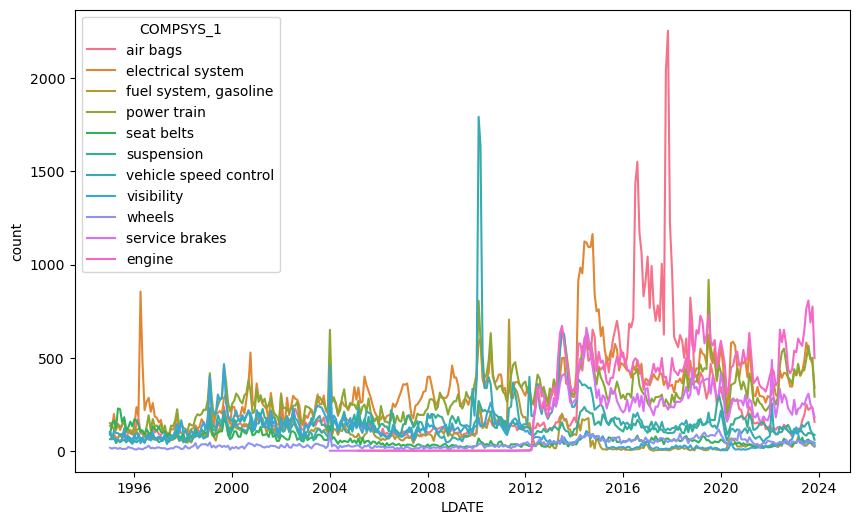

In [386]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='LDATE', y='count', data=monthly_counts, hue="COMPSYS_1")
plt.show()